# Flash Method Data Reduction Using ODRPACK 
 (c) Jozef Gembarovic 2015, 2017

 ODRPACK (Orthogonal Distance Regression  PACKage) Version 2.1 - see [manual](https://docs.scipy.org/doc/external/odrpack_guide.pdf)

### Import all necessary packages

In [1]:
%pylab inline

import numpy as np # for Numerical Python
import scipy.special as scs # for Bessel functions 
from scipy.optimize import brenth # for finding zeroes of a function
import scipy.odr.odrpack as odrpack #  for ODRPACK
import os # for files manipulatios (operating system package)
from matplotlib import pyplot # for plots
from matplotlib import gridspec # for resizing figures

Populating the interactive namespace from numpy and matplotlib


### Define sample geometry parameters and their values (in CGS units) 

In [2]:
L = 1.0 #  sample thickness
R = 6.35 # sample radius
IRI = 0.0 # irradiated radius inner
IRO = 5.35 # irradiated radius outer
VRI = 0.0 # viewed radius inner
VRO = 4.1 # viewed radius outer

### An ideal response (one dimensional heat flow, an instantaneous pulse, no heat losses)
Analytical formula for the temperature response at the rear side of a sample (at $x=L$) to an instantaneous heat pulse at the front side ($x=0$) for $t>0$ is

$$ T(t,a)=T_0+T_{max}\big[1+2\sum_{n=1}^\infty (-1)^n e^{-n^2\pi^2\frac{at}{L^2}}\big],$$

where $a$ is the thermal diffusivity and $L$ is the sample thickness. $T_0$ is the initial (baseline) temperature level and $T_{max}$ represents the maximum temperature rise of adiabatically insulated sample after the flash, which depends on the amount of heat deposited on the sample and the sample heat capacity. 

Analytical formulae for the temperature rise are usually given in a simplified, relative form, where $T_0=0$ and $T_{max}=1$.


In [3]:
def flash1D(t, a): # One dimensional ideal model (an instantaneous heat pulse, no heat losses)
    suma =0.0
    for n in range(1, 50):
        suma = suma + (-1)**n*np.exp(-((n*np.pi)**2*a*t/L**2))
    return (1+2.0*suma)

In [4]:
def flash1D1(t, a, L): # One dimensional ideal model without the loop !!!
    n = np.array(range(1, 100, 1))
    minusone = np.array((-1)**n)
    su = minusone*np.exp(-((n*np.pi)**2*a*t/L**2))
    return 1.0 + 2*su.sum()

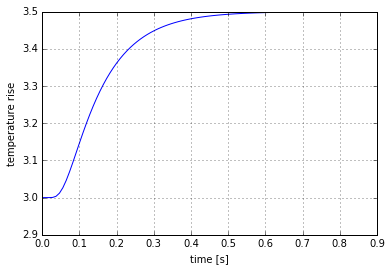

In [5]:
# testing flash1D1 without loops
time = np.linspace(0.001,.9,100) # define time points
temperature= np.array(list(map(lambda x:flash1D1(x,1.0,1.0), time)))
# kind of awkward set of callings - first converting the map to a list and then converting the list to a np.array
pyplot.plot(time, 0.5*temperature+3) 
pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.grid()
pyplot.show()

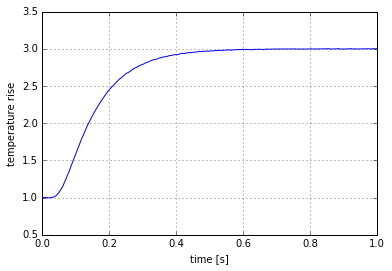

In [6]:
N=200 # number of experimental points
time = np.linspace(0.001,1.0,N) # define time points
noise = 0.001 # sigma (relative to Tmax) for noise level
baseline_theor = 1.0
Tmax_theor = 2.0
td_theor = 1.0

# calculate temperature rise
temperature=baseline_theor+Tmax_theor*(flash1D(time, td_theor) # calculate the temperature in time
    + np.random.normal(0,noise,N)) # and add Gaussian noise with sigma = noise

# plot Experimental Data
pyplot.plot(time, temperature) 
pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.grid()
pyplot.show()

### Define new dimensionless variables and functions for eigenvalues calculations

In [7]:
# calculate dimensionless radii
IRID = IRI/R
IROD = IRO/R
VRID = VRI/R
VROD = VRO/R

def rootsearch(f,a,b,Bio,dx):
    x1 = a; f1 = f(a, Bio)
    x2 = a + dx; f2 = f(x2, Bio)
    while f1*f2 > 0.0:
        if x1 >= b:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2, Bio)
    return x1,x2


def mroots(f, Bio, a, b, eps=1e-2):
    #print ('The roots on the interval [%f, %f] are:' % (a,b))
    i=0
    myroots=[]
    while 1:
        x1,x2 = rootsearch(f,a,b,Bio,eps)
        if x1 != None:
            a = x2
            #root = bisect(f,x1,x2,1)
            root = brenth(f,x1,x2, Bio, xtol=1e-16)
            if root != None:
                pass
       #     print ('root',i, root, f(root, Bio))
            myroots.append(root)
            i = i+1
        else:
            #print ('\nDone')
            return myroots
            
            break

# transcendental functions for eigenvalues calculations
def funA(x,Bio): 
    return (x*x-Bio[0]*Bio[1])*np.sin(x) - (Bio[0]+Bio[1])*x*np.cos(x)
    
def funR(x,Bio): 
    return (x*scs.j1(x) - Bio[2]*scs.j0(x))

### One Dimensional Model with heat losses
Analytical formula for temperature response at the rear face of the sample ($x=L$, $t>0$) is
$$ T(t, a, B_0, B_1) = \sum_{i=0}^\infty \frac{ 2\gamma_i^2(\gamma_i^2+B_1^2)\big(\cos{\gamma_i}+\frac{B_0}{\gamma_i}\sin{\gamma_i}\big)}{(\gamma_i^2+B_0^2)(\gamma_i^2+B_1^2)+(B_0+B_1)(\gamma_i^2+B_0B_1)}\exp{\big[-\gamma_i^2\frac{at}{L^2}\big]}, $$
where $\gamma_i$, $i=0,1,2,3,\dots$, are positive roots of 
$$ (\gamma^2-B_0B_1)\sin{\gamma} - (B_0+B_1)\cos{\gamma}=0.$$

$B_0$ and $B_1$ are Biot numbers for the front and rear side of the sample, resp. 


In [8]:
def flash1DHL(t, a, Bio, gamas): # One dimensional model with heat losses

    Bi1=Bio[0]
    Bi2=Bio[1]

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)  
    
    return suma

In [9]:
def flash1DHL1(t, a, Bio, gamas): 
    # One dimensional model with heat losses - Without loops !!!
    Bi1=Bio[0]
    Bi2=Bio[1]
    gamas = np.array(gamas)
    g2=gamas**2
    
    nom   = 2*g2*(g2+Bi2**2)*(np.cos(gamas)+Bi1/gamas*np.sin(gamas))
    denom = (g2+Bi1**2)*(g2+Bi2**2)+(Bi1+Bi2)*(g2+Bi1*Bi2)
    expon = np.exp(-g2*a*t/L**2)
    S = nom/denom*expon
    
    return S.sum()

### Two Dimensional Model with Heat Lossed and an Exponential Pulse of a Finite Duration
Analytical formula for the temperature response at the rear face of a cylidrical sample after an exponencial pulse 

$$ \psi(t)=\frac{t}{t_p^2}e^{-t/t_p},$$

with the maximum at $t_p$, is 

$$ T(t, a, B_0, B_1, B_2, t_p) = \sum_{m=0}^\infty \sum_{n=0}^\infty\Psi_m(a,B_0,B_1)\Phi_n(a,B_2)\Gamma_{mn}(t, t_p), $$

where $\Psi$ and $\Phi$ are axial and radial components:

$$ \Psi_m(t,a,B_0,B_1) =  \frac{ 2\gamma_m^2(\gamma_m^2+B_1^2)\big(\cos{\gamma_m}+\frac{B_0}{\gamma_m}\sin{\gamma_m}\big)}{(\gamma_m^2+B_0^2)(\gamma_m^2+B_1^2)+(B_0+B_1)(\gamma_m^2+B_0B_1)},$$


$$\Phi_n(t,a,B_2)=\frac{4\big(r_iJ_1(\beta_nr_i)-r_oJ_1(\beta_n r_o)\big)\big(R_iJ_1(\beta_n R_i)-R_oJ_1(\beta_n R_o)\big)}{(\beta_n^2+B_2^2)J_0(\beta_n)^2(R_o^2-R_i^2)(r_o^2-r_i^2)}, $$

$$\Gamma_{mn}=\bigg(\frac{L^2}{at_p}\bigg)^2\frac{e^{-t/t_p}}{\sigma_{mn}^2}\bigg[ \exp\bigg( - \sigma_{mn}\frac{at}{L^2}\bigg)+\sigma_{mn}\frac{at}{L^2}-1\bigg],$$

$$ \sigma_{mn}=\beta_n^2+\gamma_m^2\frac{L^2}{R^2}-\frac{L^2}{at_p}.$$

$\gamma_m$ and $\beta_n$, $m,n = 0,1,2,3,\dots$, are positive roots of 

$$ (\gamma^2-B_0B_1)\sin{\gamma} - (B_0+B_1)\cos{\gamma}=0$$

$$ \beta J_1(\beta) - B_2J_0(\beta)=0. $$

$J_0(x)$ and $J_1(x)$ are Bessel functions of the 1st kind, $R$ is the sample radius.  $R_i$ and $R_o$ are the heat pulse inner and outer radii, $r_i$ and $r_o$ are the viewed area inner and outer radii. Heat pulse and viewed area radii are dimensionles, relative to the sample radius $R$. $B_2$ is the Biot number for the lateral side of the sample. The heat pulse is coaxial to the sample main axis and the viewed area center is in the center of the rear face of the sample.


In [10]:
def flash2DHLe(t, a, Bio, gamas, betas, tp): 
    # Two dimensional model with heat losses and an exponential pulse

    Bi1=Bio[0]
    Bi2=Bio[1]
    Bi3=Bio[2]
    
    g2 = list(np.array(gamas)**2)
    b2 = list(np.array(betas)**2)

    sumaAll = 0.0
   
    for m in range(0, len(gamas)):
        for n in range(0, len(betas)):
            sigma = g2[m]+(betas[n]*L/R)**2 - L**2/a/tp
            sumaR = 4*(VRID*scs.j1(betas[n]*VRID)
            -VROD*scs.j1(betas[n]*VROD))*(IRID*scs.j1(betas[n]*IRID)
            -IROD*scs.j1(betas[n]*IROD))/((b2[n]+Bi3**2)*scs.j0(betas[n])**2
            *(IROD**2-IRID**2)*(VROD**2-VRID**2))
            sumaA = 2*g2[m]*(g2[m]+Bi2**2)/((g2[m]+Bi1**2)*(g2[m]+Bi2**2)
            +(Bi1+Bi2)*(g2[m]+Bi1*Bi2))*(np.cos(gamas[m])+Bi1/gamas[m]
            *np.sin(gamas[m]))
            Gmn = (L*L/a/tp/sigma)**2*np.exp(-t/tp)*(np.exp(-sigma*a*t/L**2)
                                                    +sigma*a*t/L**2-1.0)
            sumaAll = sumaAll + sumaA*sumaR*Gmn
            
    return sumaAll

In [11]:
def flash2DHL(t, a, Bio, gamas, betas): 
    # Two dimensional model with heat losses 

    Bi1=Bio[0]
    Bi2=Bio[1]
    Bi3=Bio[2]
    
    g2 = list(np.array(gamas)**2)
    b2 = list(np.array(betas)**2)

    sumaA = 0.0
    for i in range(0, len(gamas)):
       sumaA = sumaA + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)

    sumaR = 0.0
    for i in range(0, len(betas)):
        sumaR = sumaR + 4*(VRID*scs.j1(betas[i]*VRID)
        -VROD*scs.j1(betas[i]*VROD))*(IRID*scs.j1(betas[i]*IRID)
        -IROD*scs.j1(betas[i]*IROD))/((b2[i]+Bi3**2)*scs.j0(betas[i])**2
        *(IROD**2-IRID**2)*(VROD**2-VRID**2))*np.exp(-b2[i]*a*t/R**2)
    
    return sumaA * sumaR

In [12]:
def flash2DHL1(t, a, Bio, gamas, betas): # Two dimensional model with heat losses, without loops!

    Bi1=Bio[0]
    Bi2=Bio[1]
    Bi3=Bio[2]
    
    gamas = np.array(gamas)
    betas = np.array(betas)
    g2 = gamas**2
    b2 = betas**2
    
    # Axial component 
    nom   = 2*g2*(g2+Bi2**2)*(np.cos(gamas)+Bi1/gamas*np.sin(gamas))
    denom = (g2+Bi1**2)*(g2+Bi2**2)+(Bi1+Bi2)*(g2+Bi1*Bi2)
    expon = np.exp(-g2*a*t/L**2)
    SA = nom/denom*expon
    
    # Radial component 
    nomr = 4*(VRID*scs.j1(betas*VRID)-VROD*scs.j1(betas*VROD))*(IRID*scs.j1(betas*IRID)-IROD*scs.j1(betas*IROD))
    denomr = (b2+Bi3**2)*scs.j0(betas)**2 * (IROD**2-IRID**2)*(VROD**2-VRID**2)
    exponr = np.exp(-b2*a*t/R**2)
    SR = nomr/denomr*exponr
    
    return SA.sum() * SR.sum()

### Simulate 'experimental' data
using the Two Dimensional Model - calling the function "flash2DHL"

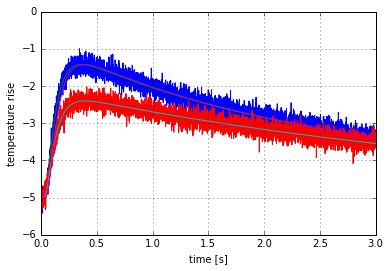

In [20]:
L = 0.10 #  sample thickness
N=200 # number of experimental points
time = np.linspace(0.0001,0.02,N) # define time points in seconds
noise = 0.05 # sigma (relative to Tmax) for noise level
# Theoretical values
# my theoretical values used for calculation of 'experimental' data, feel free to change them!
baseline_theor = -5.0
Tmax_theor = 3.0  # Tmax 
td_theor = 1.17 # thermal diffusivity in cm^2/s
Biot_theor  = 0.1 # Biot number

tp2 = 0.0005         # maximum of the exponential shape heat pulse in seconds

tp5 = 0.001        # maximum of the exponential shape heat pulse in seconds
 
# new vector of theoretical parameters 
theors = [baseline_theor, Tmax_theor, td_theor, Biot_theor] 

# define front, rear and radial Biot numbers 
Bio = [Biot_theor, Biot_theor, Biot_theor*L/R]

# calculate eigenvalues - roots of the transcendental functions
gamas = mroots(funA, Bio, 0.0001, 200)
betas = mroots(funR, Bio, 0.0001, 200)


# calculate the temperature for 2DHL1 (without loops)
temperature0= baseline_theor+Tmax_theor*np.array(list(map(lambda x:flash2DHL1(x,td_theor, Bio, gamas, betas, tp), time)))
# kind of awkward set of callings - first converting a map to a list and then converting the list to a np.array

#temperature1=baseline_theor+Tmax_theor*(flash1DHL(time, td_theor, Bio, gamas) # calculate the temperature for 1DHL in time
#    + np.random.normal(0,noise,N)) # and add Gaussian noise with sigma = noise

# calculate the temperature for 1DHL1 (without loops)
#temperature11= baseline_theor+Tmax_theor*np.array(list(map(lambda x:flash1DHL1(x,td_theor, Bio, gamas), time)))
# kind of awkward set of callings - first converting the map to a list and then converting the list to a np.array

# calculate temperature rise usind flash2DHLe with a finite exponential pulse
temperature2=baseline_theor+Tmax_theor*(flash2DHLe(time, td_theor, Bio, gamas, betas, tp2))
temperature5=baseline_theor+Tmax_theor*np.array(list(map(lambda x:flash2DHLe1(x,td_theor, Bio, gamas, betas,tp5), time)))

temperature2n=baseline_theor+Tmax_theor*(flash2DHLe(time, td_theor, Bio, gamas, betas, tp2)
                                        + np.random.normal(0,noise,N))

# plot Experimental Data
#pyplot.plot(time, temperature) 
pyplot.plot(time, temperature0,'b', label='tp = 0 ms') 
pyplot.plot(time, temperature2,'r', label='tp = 0.5 ms') 
#pyplot.plot(time, temperature1) 
#pyplot.plot(time, temperature11) 
pyplot.plot(time, temperature5,'g', label='tp = 1.0 ms') 
pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()
pyplot.show()
# it is clear thet the pulse shape and duration are important for a Copper sample  ~ 1 mm thick !

In [ ]:
pyplot.plot(time, temperature2n,'b.', label='simulated') 
pyplot.plot(time, temperature2,'r', label='theory, tp = 0.5 ms') 

pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()
pyplot.show()

### Here goes ODRPACK

In [16]:
# first delete the file 'filename' if it already exist to make room for a new one, generated by the ODRPACK
filename="res2DHLexpODR.txt" 
## delete only if file exists ##
if os.path.exists(filename):
    os.remove(filename)
else:
    print("Sorry, I can not remove %s file." % filename)
    
# define analytical function for temperature distribution used by the fitting procedure
def f2DHLe(B, t):
    Bio = [B[3], B[3], B[3]*L/R]
    gamas = mroots(funA, Bio, 0.0001, 100) # calculate the first ~ 80 positive roots
    betas = mroots(funR, Bio, 0.0001, 100) 
    #return B[0]+B[1]*flash2DHL(x, B[2], Bio, gamas, betas) 
    return B[0]+B[1]*np.array(list(map(lambda x:flash2DHLe1(x,B[2], Bio, gamas, betas, tp2), t))) 
    # flash2DHL without loops was used for the fitting
flash = odrpack.Model(f2DHLe) # our model will use 2D model with heat losses

mydata = odrpack.RealData(time, temperature2n, sx=0.00001, sy=0.0001) 
# use already simulated data. sx and sy are uncertainties for time and temperature points, resp.

myodr = odrpack.ODR(mydata, flash, beta0=[-5.,3.5, 1.0, 0.08], job=3, # input parameters - beta0 are initial guess values
                    iprint=6616, ifixb=[1,1,1,1], rptfile=filename)             # for the baseline level, Beta[0], Tmax, Beta[1], 
                                                                # the thermal diffusivity, Beta[2], 
                                                                # and the Biot number, Beta[3] 
                                                    
myoutput = myodr.run() # run Forrest (ODRPACK), run!!
myoutput.pprint() # print a standard simple output

# a more detail report from the ODRPACK is in a freshly created text file "results2Dodr.txt"  
# real time = 40 s, on work PC

Beta: [-5.05198073  3.0356824   1.18102691  0.09645218]
Beta Std Error: [ 0.01909618  0.01244264  0.00864278  0.00180069]
Beta Covariance: [[  1.72040919e-10  -9.98340455e-11  -3.70010598e-11   1.31191109e-11]
 [ -9.98340455e-11   7.30405889e-11   1.22926304e-11  -5.49710583e-12]
 [ -3.70010598e-11   1.22926304e-11   3.52407998e-11  -6.23664241e-12]
 [  1.31191109e-11  -5.49710583e-12  -6.23664241e-12   1.52972932e-12]]
Residual Variance: 2119635.275761684
Inverse Condition #: 0.0049616510406394025
Reason(s) for Halting:
  Sum of squares convergence


### Reconstruct the theoretical temperature rise from calculated parameters 

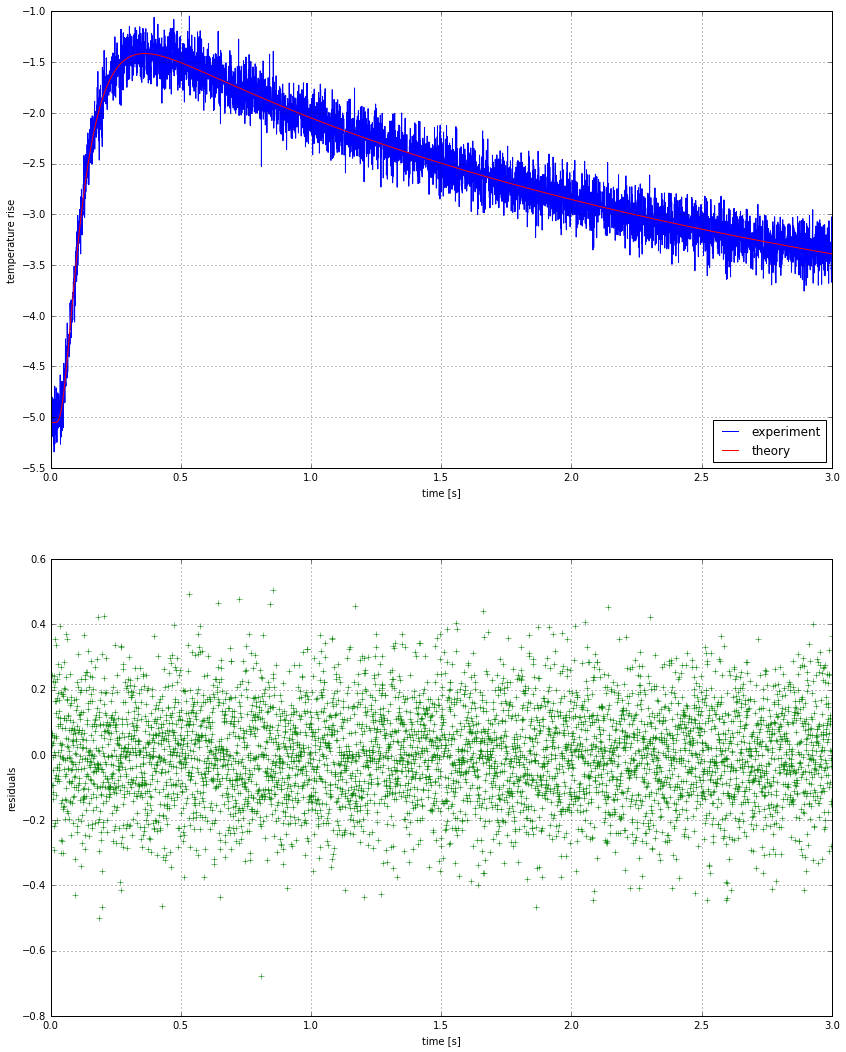

Relative errors [baseline level, Tmax, thermal diffusivity, Biot number] in percent are: 
 [ 1.03961462  1.18941336  0.94247084 -3.54782149]

 
 Histogram of residuals


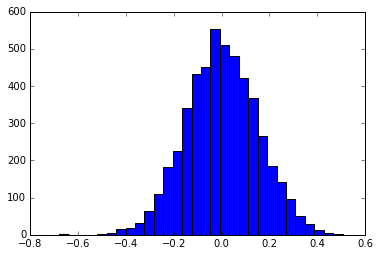

In [17]:
B = myoutput.beta # final results of calculated optimal parameters
Bio=[B[3],B[3],B[3]*L/R]
gamas = mroots(funA, Bio, 0.0001, 200)
betas = mroots(funR, Bio, 0.0001, 200) 
theory = B[0]+B[1]*flash2DHLe(time, B[2], Bio, gamas, betas,tp2) 


fig = pyplot.figure(figsize=(14, 18)) 

pyplot.figure(1)
pyplot.subplot(211)
pyplot.plot(time, temperature2n, 'b.', label="experiment")
pyplot.plot(time, theory,'r', label="theory")
pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()

residuals = temperature2n - theory

pyplot.subplot(212)
pyplot.plot(time, residuals, 'g+', label="residuals")
pyplot.xlabel("time [s]")
pyplot.ylabel("residuals")
pyplot.grid()

pyplot.show()

pyplot.hist(residuals, 30) # plot histogram of residuals

# calculate relative errors
errors = (B-theors)/theors*100 
errors
print ("Relative errors [baseline level, Tmax, thermal diffusivity, Biot number] in percent are: \n",errors)
print ("\n \n Histogram of residuals")
